In [19]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_regression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error, explained_variance_score
import joblib
from sklearn.preprocessing import PowerTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer


In [20]:
def build_gru_model(input_shape):
    model = Sequential()
    model.add(GRU(units=32, return_sequences=True, input_shape=input_shape))
    model.add(GRU(units=32))
    model.add(Dense(units=16, activation='relu'))
    model.add(Dense(units=1))
    return model

def calculate_metrics(y_test, y_pred):
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    evs = explained_variance_score(y_test, y_pred)
    return mae, mse, evs

def create_dataset_with_steps(time_series, look_back=1, step=1):
    X, y = [], []
    for i in range(0, len(time_series) - look_back, step):
        X.append(time_series[i:(i + look_back), 0])
        y.append(time_series[i + look_back, 0])
    return np.array(X), np.array(y)



In [41]:

def train_and_plot_model(model, X_train, y_train, epochs=60):
    model.compile(optimizer='adam', loss='mean_squared_error')
    history = model.fit(X_train, y_train, epochs=epochs, validation_split=0.2, batch_size=32)

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

In [21]:
def histogram_plot(data):
    numeric_col = data.select_dtypes(include=[np.number])
    numeric_col.hist(bins=50, figsize=(20, 20))
    plt.hist(data, bins=50, alpha=0.75)
    plt.title('Histogram of the data')
    plt.show()

In [22]:
data = pd.read_csv("../data/raw/og_dataset.csv")
print(data.head())



data['date'] = pd.to_datetime(data['date'])
data.sort_values(by='date', inplace=True)
features = ['available_bike_stands', 'temperature', 'relative_humidity',
             'apparent_temperature', 'dew_point', 'precipitation_probability',
               'surface_pressure','bike_stands', 'rain']
data = data[['date'] + features]

data.isnull().sum()


missing_values = data.isnull().sum()


    
data = data.copy()
missing_values_cols = data.columns[data.isnull().any()].tolist()
complete_values_cols = data.drop(missing_values_cols + ["date"], axis=1).columns.tolist()

missing_data = data[data.isnull().any(axis=1)]
complete_data = data.dropna()

for column in missing_values_cols:
    X = complete_data[complete_values_cols]
    y = complete_data[column]
    
    model = RandomForestRegressor()
    model.fit(X, y)
    
    missing_X = missing_data[complete_values_cols]
    predictions = model.predict(missing_X)
    
    data.loc[missing_data.index, column] = predictions

missing_values = data.isnull().sum()

print(missing_values)


#AGGREGATING DATA TO INTERVAL

data.set_index('date', inplace=True)

agg_data = data.resample('H').mean()

agg_data.reset_index(inplace=True)

data = agg_data
data.dropna(inplace=True)
print(data.isnull().sum())


   Unnamed: 0                       date  temperature  relative_humidity  \
0           0  2023-06-25 19:07:30+00:00         25.1                 45   
1           1  2023-06-25 20:25:41+00:00         24.2                 43   
2           2  2023-06-25 20:12:20+00:00         24.2                 43   
3           3  2023-06-25 19:33:48+00:00         24.2                 43   
4           4  2023-06-25 19:55:29+00:00         24.2                 43   

   dew_point  apparent_temperature  precipitation_probability  rain  \
0       12.4                  24.7                        0.0   0.0   
1       10.9                  23.3                        NaN   0.0   
2       10.9                  23.3                        0.0   0.0   
3       10.9                  23.3                        0.0   0.0   
4       10.9                  23.3                        NaN   0.0   

   surface_pressure  bike_stands  available_bike_stands  
0             984.3           22                      8  


date                         0
available_bike_stands        0
temperature                  0
relative_humidity            0
apparent_temperature         0
dew_point                    0
precipitation_probability    0
surface_pressure             0
bike_stands                  0
rain                         0
dtype: int64
date                         0
available_bike_stands        0
temperature                  0
relative_humidity            0
apparent_temperature         0
dew_point                    0
precipitation_probability    0
surface_pressure             0
bike_stands                  0
rain                         0
dtype: int64


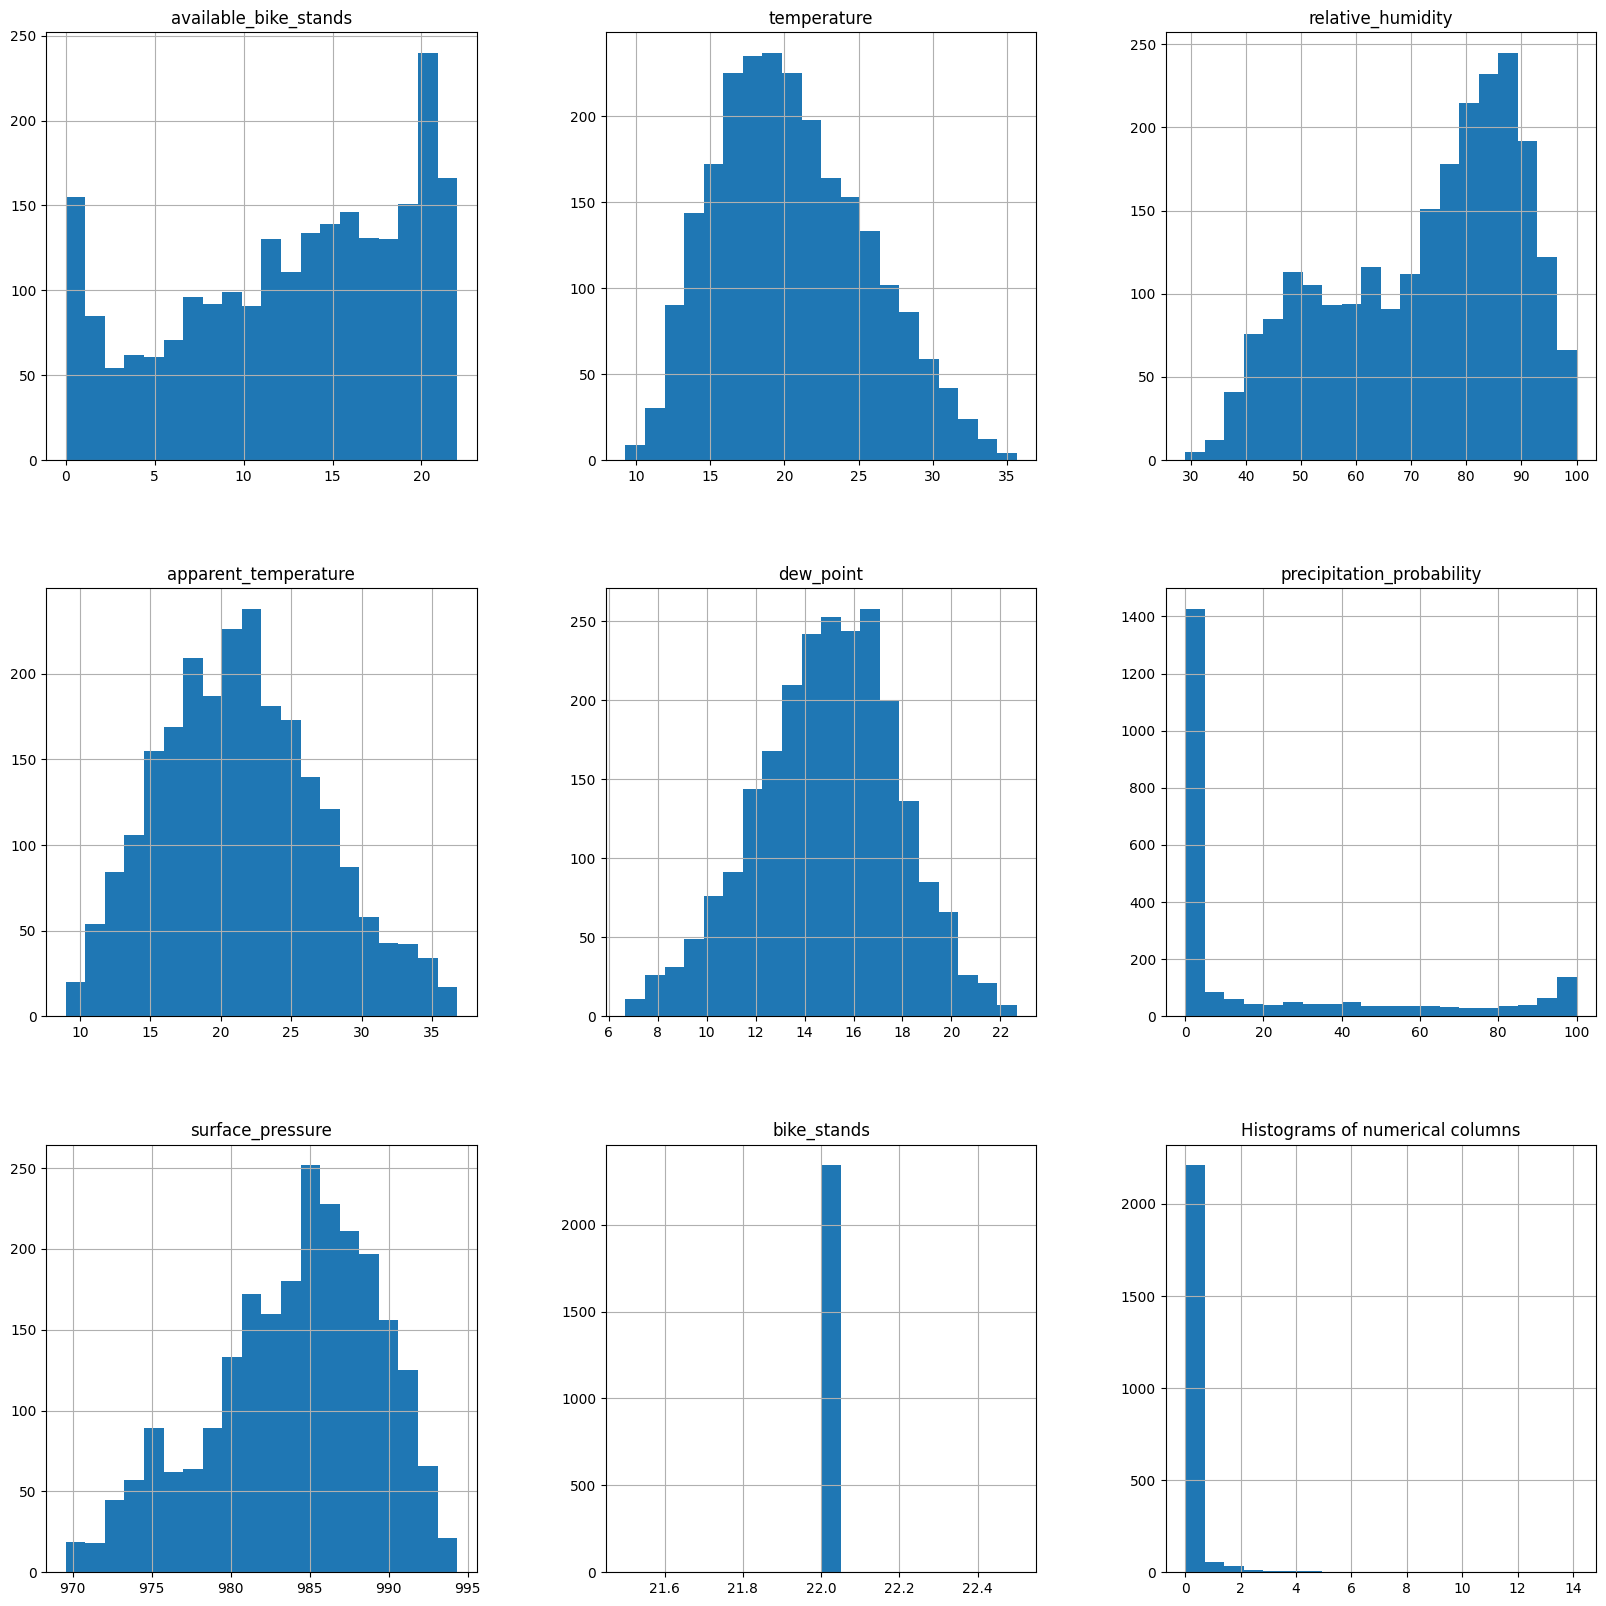

In [23]:
def plot_histograms(df):
    numeric_columns = df.select_dtypes(include=['number'])
    numeric_columns.hist(bins=20, figsize=(20, 20))
    plt.title("Histograms of numerical columns")
    plt.show()
plot_histograms(data)        

In [24]:
def printSkew():
  skewness_info = []
  for column in data.columns[1:]:
      skew = data[column].skew()
      skewness_info.append((column, skew))

  skewness_df = pd.DataFrame(skewness_info, columns=['Column Name', 'Skewness'])

  print(skewness_df)
printSkew()

                 Column Name  Skewness
0      available_bike_stands -0.423455
1                temperature  0.364736
2          relative_humidity -0.500495
3       apparent_temperature  0.263880
4                  dew_point -0.211922
5  precipitation_probability  1.322673
6           surface_pressure -0.519311
7                bike_stands  0.000000
8                       rain  9.577575


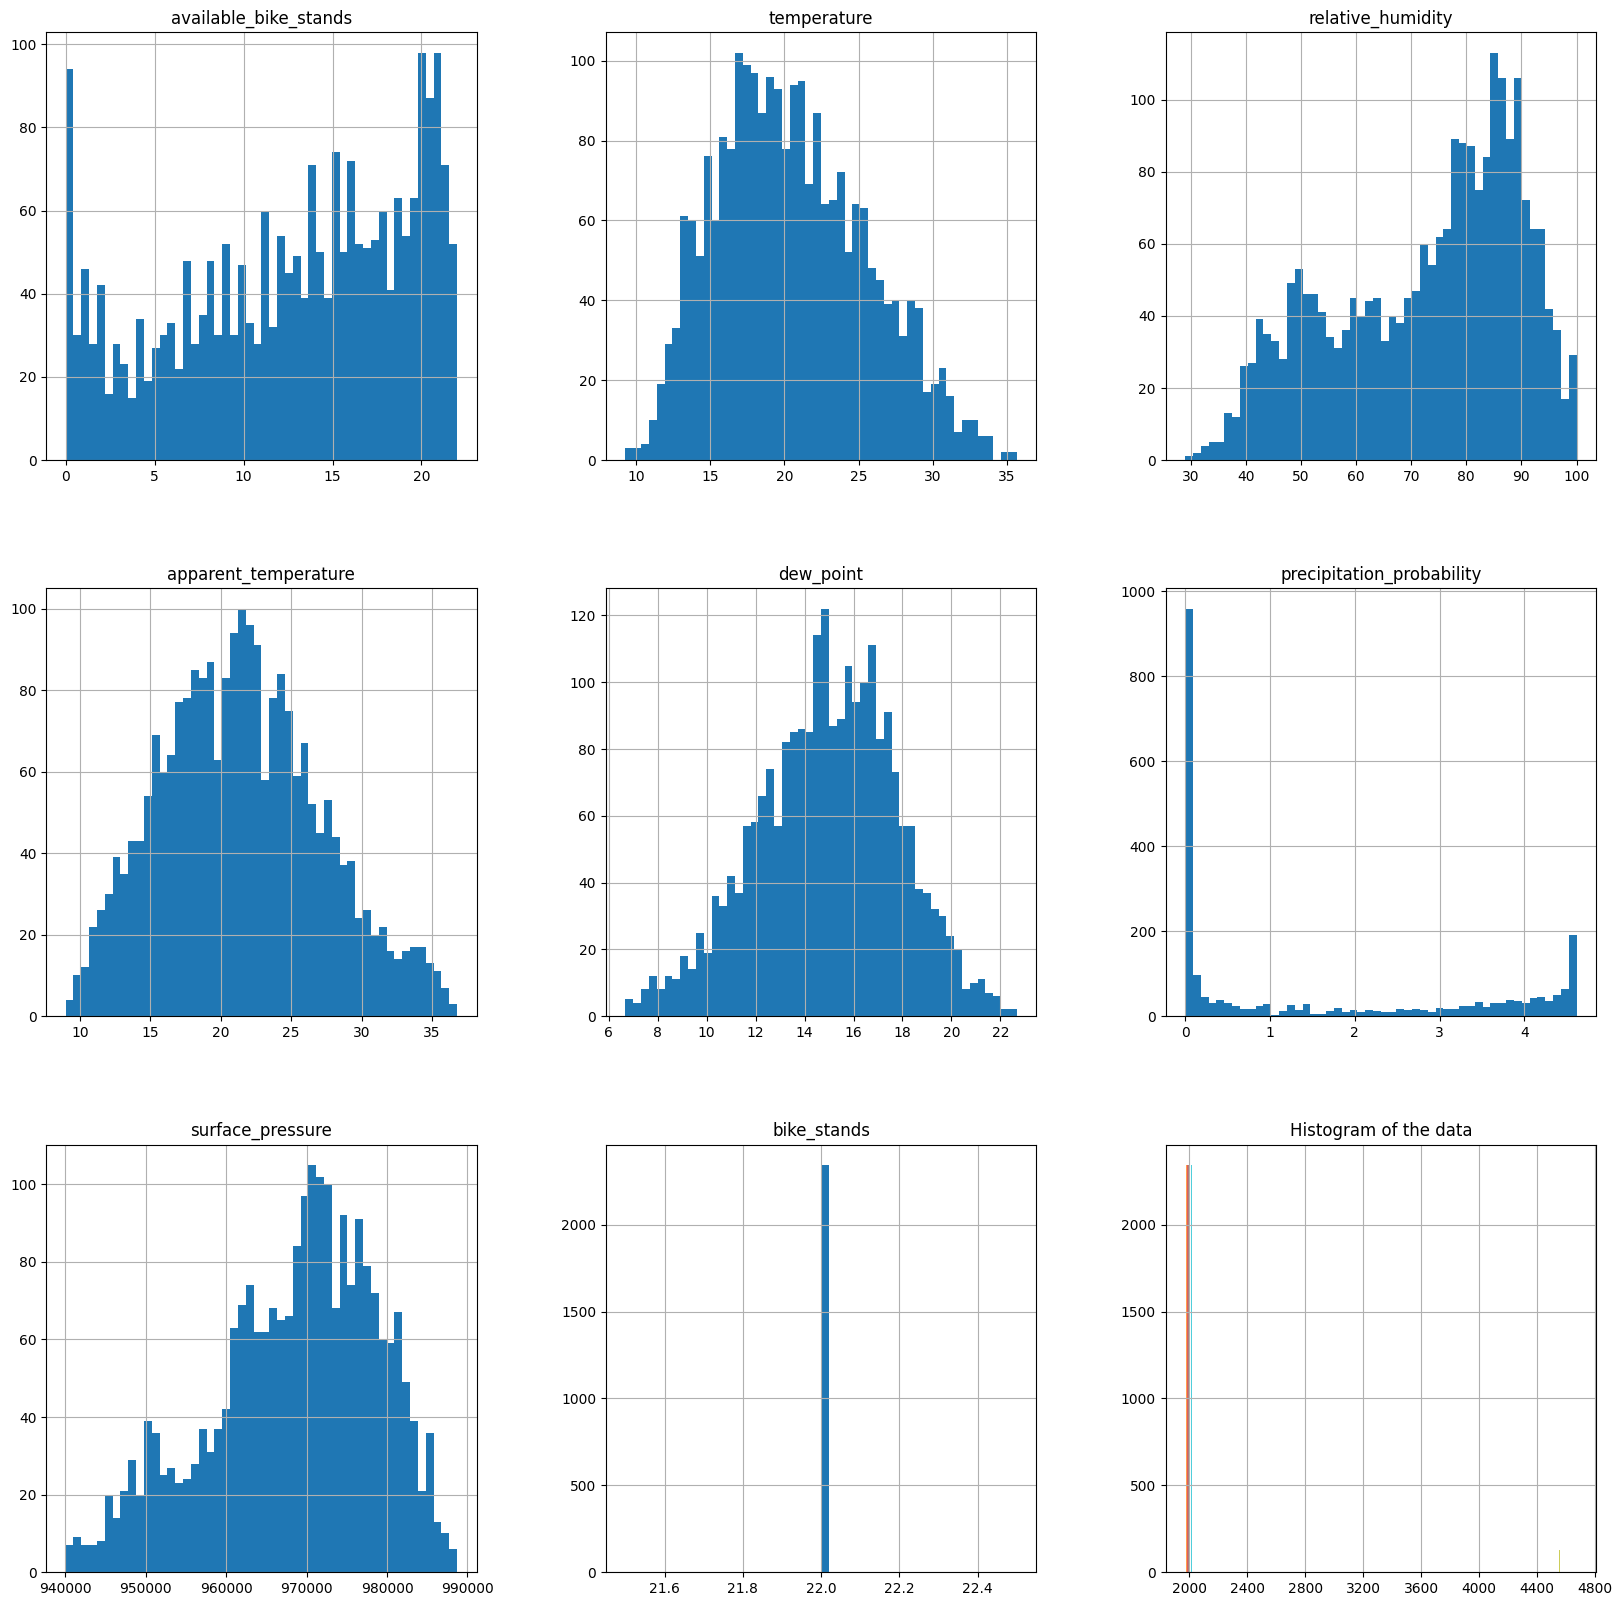

['surface_pressure']


In [25]:
left_skew_columns = ["surface_pressure"]
for col in left_skew_columns:
    data[col] = np.square(data[col])

right_skew_columns = ["rain", "precipitation_probability"]
for col in right_skew_columns:
    data[col] = np.log(data[col]+1 )

histogram_plot(data)

#INFO GAINS
target = data['available_bike_stands']
features = data.drop(columns=['available_bike_stands', 'date'])

info_gains = mutual_info_regression(features, target)

info_gains = pd.Series(info_gains, index=features.columns)
info_gains.sort_values(ascending=False, inplace=True)

threshold = 0.1

selected_features = info_gains[info_gains > threshold].index.tolist()
print(selected_features)


In [34]:
selected_features = ['temperature',
        'apparent_temperature',
        'surface_pressure',
        'dew_point',
        'precipitation_probability',
        'relative_humidity', "rain"]

learn_features = data[ ['available_bike_stands']+ list(selected_features)]
learn_features = learn_features.values

learn_features

array([[ 7.25      , 24.42925   , 23.65      , ...,  0.34712953,
        43.5       ,  0.        ],
       [ 8.5       , 22.85716667, 22.5       , ...,  0.38752741,
        49.        ,  0.        ],
       [ 4.33333333, 20.95      , 21.05      , ...,  0.        ,
        56.5       ,  0.        ],
       ...,
       [20.18181818, 24.27272727, 26.12727273, ...,  0.        ,
        63.81818182,  0.        ],
       [19.41666667, 25.55      , 27.35      , ...,  0.09379388,
        59.        ,  0.        ],
       [12.875     , 26.23375   , 27.875     , ...,  0.31845373,
        55.5       ,  0.        ]])

In [37]:
train_size = len(learn_features) - 384 - 48
train_data, test_data = learn_features[:train_size], learn_features[train_size:]
train_data.shape, test_data.shape


train_stands = np.array(train_data[:,0])
test_stands = np.array(test_data[:,0])
stands_scaler = MinMaxScaler()
train_stands_normalized = stands_scaler.fit_transform(train_stands.reshape(-1, 1))
test_stands_normalized = stands_scaler.transform(test_stands.reshape(-1, 1))

train_final_stands = np.array(learn_features[:, 0])
train_final_stands_normalized = stands_scaler.fit_transform(train_final_stands.reshape(-1, 1))
train_other = np.array(train_data[:,1:])
test_other = np.array(test_data[:,1:])
other_scaler = MinMaxScaler()
train_other_normalized = other_scaler.fit_transform(train_other)
test_other_normalized = other_scaler.transform(test_other)

train_final_other = np.array(learn_features[:, 1:])
train_final_other_normalized = other_scaler.fit_transform(train_final_other)

train_normalized = np.column_stack([train_stands_normalized, train_other_normalized])
test_normalized = np.column_stack([test_stands_normalized, test_other_normalized])

train_final_normalized = np.column_stack([train_final_stands_normalized, train_final_other_normalized])

In [38]:
def create_multivariate_dataset_with_steps(time_series, look_back=1, step=1):
    X, y = [], []
    for i in range(0, len(time_series) - look_back, step):
        X.append(time_series[i:(i + look_back), :])
        y.append(time_series[i + look_back, 0]) 
    return np.array(X), np.array(y)

look_back = 48
step = 1

X_train, y_train = create_multivariate_dataset_with_steps(train_normalized, look_back, step)
X_test, y_test = create_multivariate_dataset_with_steps(test_normalized, look_back, step)

X_final, y_final = create_multivariate_dataset_with_steps(train_final_normalized, look_back, step)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[2], X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[2], X_test.shape[1])

X_final = X_final.reshape(X_final.shape[0], X_final.shape[2], X_final.shape[1])


print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (1864, 8, 48)
X_test shape: (384, 8, 48)


In [40]:
input_shape = (X_train.shape[1], X_train.shape[2])

Epoch 1/60
47/47 [==============================] - 13s 65ms/step - loss: 0.1373 - val_loss: 0.1060
Epoch 2/60
47/47 [==============================] - 1s 23ms/step - loss: 0.0580 - val_loss: 0.0827
Epoch 3/60
47/47 [==============================] - 1s 25ms/step - loss: 0.0427 - val_loss: 0.0642
Epoch 4/60
47/47 [==============================] - 1s 20ms/step - loss: 0.0315 - val_loss: 0.0462
Epoch 5/60
47/47 [==============================] - 1s 22ms/step - loss: 0.0243 - val_loss: 0.0293
Epoch 6/60
47/47 [==============================] - 1s 27ms/step - loss: 0.0224 - val_loss: 0.0269
Epoch 7/60
47/47 [==============================] - 1s 22ms/step - loss: 0.0198 - val_loss: 0.0247
Epoch 8/60
47/47 [==============================] - 1s 23ms/step - loss: 0.0178 - val_loss: 0.0231
Epoch 9/60
47/47 [==============================] - 1s 24ms/step - loss: 0.0166 - val_loss: 0.0236
Epoch 10/60
47/47 [==============================] - 1s 24ms/step - loss: 0.0159 - val_loss: 0.0207
Epoch 11

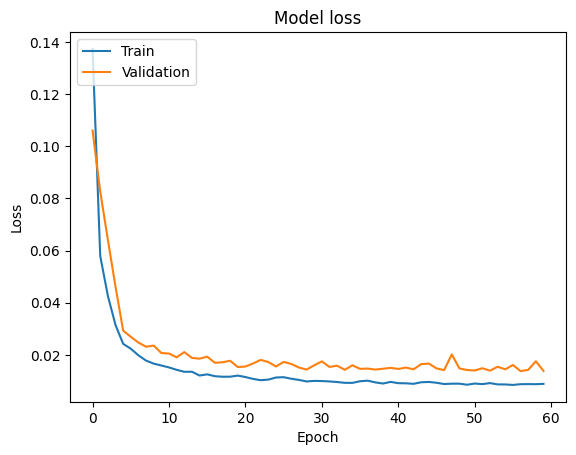

In [42]:
model = build_gru_model(input_shape)
train_and_plot_model(model, X_train, y_train, epochs=60)

In [43]:
y_test_pred = model.predict(X_test)

12/12 [==============================] - 2s 6ms/step


In [44]:
y_test_true = stands_scaler.inverse_transform(y_test.reshape(-1, 1))

y_test_pred__adv = stands_scaler.inverse_transform(y_test_true)

In [46]:
def calculate_metrics(y_test, y_pred):
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    evs = explained_variance_score(y_test, y_pred)
    return mae, mse, evs

In [47]:
mae,mse,evs = calculate_metrics(y_test_true, y_test_pred__adv)
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"EVS: {evs}")

MAE: 252.11578373883063
MSE: 85263.71356038564
EVS: -440.0


In [ ]:
dates = data['date'][:-look_back][-len(y_test):]
train_dates =  data['date'][:len(train_data)]


print(dates.shape)
# Function to plot a comparison between actual values and predictions for a given model
def plot_comparison(train_dates, train_data, test_dates, y_pred_inverse, y_test_inverse, model_name, color1, color2, mae, mse, evs):
    plt.figure(figsize=(20, 6))
    plt.title(f'Razpoložljiva stojala {model_name}\nMAE: {mae:.2f}, MSE: {mse:.2f}, EVS: {evs:.2f}')
    plt.xlabel('Datum')
    plt.ylabel('Kolesarska stojala')
    plt.xticks(rotation=45)
    plt.plot(test_dates, y_test_inverse, color='purple', label='Dejanske vrednosti')
    plt.plot(test_dates, y_pred_inverse, color=color2, label=f'Napoved')
    plt.plot(train_dates, train_data, color=color1, label='Učna množica')
    plt.legend()
    plt.tight_layout()
    plt.show()



# Plotting LSTM predictions
plot_comparison(
    train_dates,
    train_data[:,0],
    dates,
    y_test_true,
    y_test_pred__adv,
    'LSTM',
    'blue',
    'orange',
    mae,
    mse,
    evs
)

### ---------------------------------------------------------------------------------

In [49]:
test_size = 0.05 #5%
train_size = int(len(learn_features) * (1 - test_size))
print(f"Train size: {train_size}")

test_size = len(learn_features) - train_size
print(f"Test size: {test_size}")

#velikost okenca za 7 dni
window_size = test_size/7
window_size = int(window_size)
print(f"Window size: {window_size}")

Train size: 2226
Test size: 118
Window size: 16


In [50]:

train_size = int(len(learn_features)-window_size) 
train_data = learn_features[:train_size]
test_data = learn_features[train_size:]

X_train = train_data.drop(columns=['available_bike_stands'])
y_train = train_data['available_bike_stands']

X_test = test_data.drop(columns=['available_bike_stands'])
y_test = test_data['available_bike_stands']

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

joblib.dump(scaler, '../models/multi/scaler.pkl')

look_back = window_size

X_train, y_train = create_dataset_with_steps(X_train, look_back=look_back, step=1)
X_test, y_test = create_dataset_with_steps(X_test, look_back=look_back, step=1)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[2],X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[2], X_train.shape[1])

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
    

input_shape = (X_train.shape[1], X_train.shape[2])

print(input_shape)

AttributeError: 'numpy.ndarray' object has no attribute 'drop'

In [ ]:

def train_and_plot_model(model, X_train, y_train, epochs=60):
    model.compile(optimizer='adam', loss='mean_squared_error')
    history = model.fit(X_train, y_train, epochs=epochs, validation_split=0.2, batch_size=32)

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()


input_shape = (X_train.shape[1], 1)
model = build_gru_model(input_shape)
train_and_plot_model(model, X_train, y_train, epochs=20)

model.save('../models/multi/gru_model.h5')


   surface_pressure  available_bike_stands
0         -0.034507              -0.849713
1         -0.034507              -0.659929
2         -0.014499              -1.285920
3          0.076636              -1.836529
4          0.128050              -1.882126


14/14 [==============================] - 0s 6ms/step
Mean Absolute Error: 3.1924513019269223
Mean Squared Error: 15.16309645498444
Explained Variance Score: 0.38287544903480375


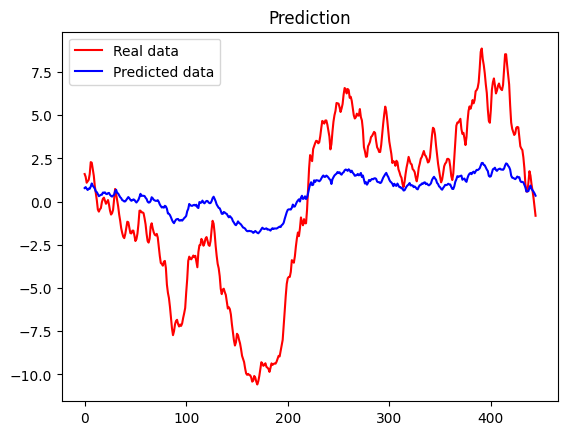

KeyError: 'date'

In [ ]:
y_pred = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

mae, mse, evs = calculate_metrics(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"Explained Variance Score: {evs}")

plt.plot(y_test, color='red', label='Real data')
plt.plot(y_pred, color='blue', label='Predicted data')
plt.title('Prediction')
plt.legend()
plt.show()

dates = data['date'][:-24][-len(y_test):]
train_dates =  data['date'][:len(train_data)]


print(dates.shape)
# Function to plot a comparison between actual values and predictions for a given model
def plot_comparison(train_dates, train_data, test_dates, y_pred_inverse, y_test_inverse, model_name, color1, color2, mae, mse, evs):
    plt.figure(figsize=(20, 6))
    plt.title(f'Razpoložljiva stojala {model_name}\nMAE: {mae:.2f}, MSE: {mse:.2f}, EVS: {evs:.2f}')
    plt.xlabel('Datum')
    plt.ylabel('Kolesarska stojala')
    plt.xticks(rotation=45)
    plt.plot(test_dates, y_test_inverse, color='purple', label='Dejanske vrednosti')
    plt.plot(test_dates, y_pred_inverse, color=color2, label=f'Napoved')
    plt.plot(train_dates, train_data, color=color1, label='Učna množica')
    plt.legend()
    plt.tight_layout()
    plt.show()



# Plotting LSTM predictions
plot_comparison(
    train_dates,
    train_data[:,0],
    dates,
    y_pred.flatten(),
    y_test.flatten(),
    'LSTM',
    'blue',
    'orange',
    mae,
    mse,
    evs
)

### --------------------------------------

In [ ]:
data = pd.read_csv("../data/raw/og_dataset.csv")

# sortiranje 
data['date'] = pd.to_datetime(data['date'])

target_feature = 'available_bike_stands'
data = data[['date', target_feature]].dropna()  # Izberemo samo zapise z znanimi vrednostmi ciljne značilnice
bike_series = np.array(data[target_feature].values.reshape(-1, 1))

bike_series

train_size = len(bike_series) - 1302 -186
train_data, test_data = bike_series[:train_size], bike_series[train_size:]

scaler = MinMaxScaler()
train_data_normalized = scaler.fit_transform(train_data)
test_data_normalized = scaler.transform(test_data)
joblib.dump(scaler, '../models/scaler.pkl')


look_back = 186  # Velikost okna
step = 1  # Korak pomika

X_train, y_train = create_dataset_with_steps(train_data_normalized, look_back, step)
X_test, y_test = create_dataset_with_steps(test_data_normalized, look_back, step)

# Oblika vhodnih učnih podatkov
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

input_shape = (X_train.shape[1], X_train.shape[2])

gru_model = build_gru_model(input_shape)

gru_model.compile(optimizer='adam', loss='mean_squared_error')
gru_model.fit(X_train, y_train, epochs=25, batch_size=32, validation_split=0.2, verbose=1)

gru_model.save('../models/base_data_model.h5')


# Evaluate the model on the TEST DATA
y_pred = gru_model.predict(X_test)


# get mae, mse, evs for test data
gru_mae_test, gru_mse_test, gru_evs_test = calculate_metrics(y_test, y_pred)

 
print("\nGRU Model Metrics:")
print(f"MAE: {gru_mae_test}, MSE: {gru_mse_test}, EVS: {gru_evs_test}")

with open('../reports/metrics.txt', 'w', encoding='utf-8', errors='replace') as f:
        f.write(f'Mean average error: {gru_mae_test}\nMean square error: {gru_mse_test}\nExplained variance score: {gru_evs_test}\n')



#TRAIN DATA

y_test_pred_gru = gru_model.predict(X_test)

y_test_true = scaler.inverse_transform(y_test.reshape(-1, 1))

y_test_pred_gru = scaler.inverse_transform(y_test_pred_gru)

gru_mae, gru_mse, gru_evs = calculate_metrics(y_test_true, y_test_pred_gru)


print("\nGRU Model Metrics:")
print(f"MAE: {gru_mae}, MSE: {gru_mse}, EVS: {gru_evs}")

with open('../reports/train_metrics.txt', 'w', encoding='utf-8') as f:
        f.write(f'Mean average error: {gru_mae}\nMean square error: {gru_mse}\nExplained variance score: {gru_evs}\n')

